# Comparing Gridded and Random Folds

To evaluate machine learning models, it is common to use [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) to measure how well a model trained on one dataset will generalize to a new dataset. Cross validation works by splitting a dataset into "folds" (a partitioning of the dataset into non-overlapping subsets), training on one subset of folds, and evaluating on another subset. It is a common strategy to randomly split data into folds, but in some scenarios, this can affect the robustness of estimates of generalization performance. We will explore this phenomenon in this exercise.

## Setup

First, the following cells import required Python modules and define some functions that will be useful for the analysis:

In [1]:
# Imports
%env MPLCONFIGDIR=/tmp/.cache
import os
import numpy as np
import rioxarray
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

env: MPLCONFIGDIR=/tmp/.cache


In [2]:
# Constants
DATA_DIRECTORY = '/home/jovyan/shared/NASA_Summer_School_2024/tree_mortality/materials/data'

# Fold files contain fold definitions on spatial grid
GRIDDED_FOLD_FILE = os.path.join(DATA_DIRECTORY, 'tree_mortality_gridded_folds.nc4')
RANDOM_FOLD_FILE = os.path.join(DATA_DIRECTORY, 'tree_mortality_random_folds.nc4')

# Data files contain flattened, tabular representation of data for model training
GRIDDED_DATA_FILE = os.path.join(DATA_DIRECTORY, 'tree_mortality_gridded_training_nonzero.nc4')
RANDOM_DATA_FILE = os.path.join(DATA_DIRECTORY, 'tree_mortality_random_training_nonzero.nc4')

TRAINING_VARIABLES = [
    'PR1-1', 'PRET1-1',
    'SPI1-1', 'SPI1-2', 'SPI1-3', 'SPI1-4','SPI1-5', 'SPI1-6',
    'SPEI1-1', 'SPEI1-2', 'SPEI1-3', 'SPEI1-4','SPEI1-5', 'SPEI1-6',
]

In [3]:
# Function Definitions

def plot_fold_comparison(ds_gridded, ds_random):
    """
    Plots a side-by-side comparison of gridded and random folds
    """
    datasets = [ds_gridded, ds_random]
    names = ['Gridded', 'Random']

    # Get coordinate reference system (CRS) for datasets
    crs = [
        ccrs.Projection(ds_gridded.rio.crs),
        ccrs.Projection(ds_random.rio.crs)
    ]
    
    # Define CRS for plot
    proj = ccrs.AlbersEqualArea(
        central_longitude=-120, standard_parallels=(34, 40.5)
    )
    
    fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection=proj))
    for ax, ds, name, crs in zip(axs, datasets, names, crs):
        values = ((ds.fold.transpose() + 1) % 20)
        values.plot(
            ax=ax, transform=crs,
            cmap='tab20b', alpha=0.75, add_colorbar=False,
        )
        ax.set_title(name, fontsize=14)
        ax.coastlines()
        ax.add_feature(cfeature.STATES.with_scale('50m'))


def filter_inf(X, y=None, fill=1e2):
    """
    Returns a version of the dataset in which infinite values have been
    replaced with a given finite fill value
    """
    if np.any(np.isnan(X)):
        raise ValueError('NaN entries present but not handled')
        
    Xnew = np.nan_to_num(X, neginf=-fill, posinf=fill)
    
    return Xnew if y is None else (Xnew, y)


def load_training_set(datafile, year=None, target='tpa'):
    """
    Loads a training dataset from the specified file, selecting a specific
    year if given.

    @param datafile: NetCDF4 data file path to load
    @param year: `None`, or `int` year to select

    @return (X, y, groups), where X is the feature matrix, y are the
        mortality labels, and groups are pre-defined data splits
    """

    # Open dataset and select year (if specified)
    ds = xr.open_dataset(datafile)
    if year is not None:
        ds = ds.where(ds.year == year, drop=True)

    # Drop all variables except for the desired features
    X = ds[TRAINING_VARIABLES].to_array().T

    # Get target mortality values
    y = ds[target].as_numpy()

    # Filter infinite values
    X, y = filter_inf(X, y)

    # Get group definitions
    groups = ds['fold'].values.astype(int)
    
    return X, y, groups


def run_evaluation(X, y, groups, n_splits=64):
    cv = GroupKFold(n_splits=n_splits)
    model = RandomForestRegressor(
        n_estimators=10, max_depth=5,
    )
    results = cross_validate(
        model, X, y, groups=groups, cv=cv,
        scoring='neg_mean_squared_error',
        verbose=1, n_jobs=-1,
    )

    # Neg. MSE to MSE
    return -results['test_score']


def compare_scores(gridded_score, random_scores):
    stats = [
        (np.average(scores), np.std(scores) / np.sqrt(len(scores)))
        for scores in (gridded_scores, random_scores)
    ]
    sig_results = ttest_ind(gridded_scores, random_scores, equal_var=False)
    print(f'Gridded MSE: {stats[0][0]:.1f} +/- {stats[0][1]:.2f}')
    print(f' Random MSE: {stats[1][0]:.1f} +/- {stats[1][1]:.2f}')
    print(f'    p-value: {sig_results.pvalue:.3f}')

## Fold Definitions

This section loads the fold definition files and plots the fold number over a spatial grid. In the gridded fold definition, contiguous 27x27 km regions of grid cells are grouped into the same fold. In the random definition, each grid cell is randomly assigned, so adjacent cells are likely to belong to different folds. The plot cycles through 20 colors to represent each fold.

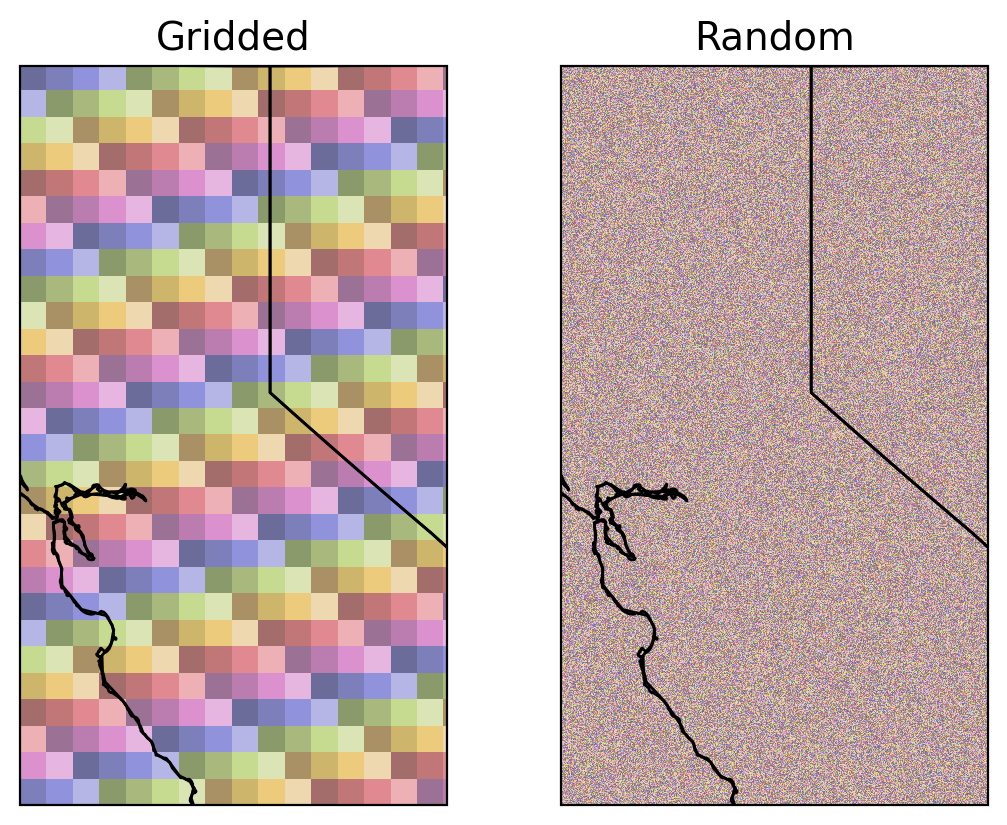

In [4]:
gridded_fold = xr.open_dataset(GRIDDED_FOLD_FILE)
random_fold = xr.open_dataset(RANDOM_FOLD_FILE)
plot_fold_comparison(gridded_fold, random_fold)

## Model Training

In this section, we will load the full dataset, train, and evaluate classifiers using _k_-fold cross validation. Because we manually defined our own groupings of pixels, we will use the [`GroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold) class in `scikit-learn` to combine our groups into a smaller set of _k_&nbsp;=&nbsp;5 folds such that each of our groups belongs to only a single larger fold (i.e., the groups we defined are not split across these larger folds).

The `load_training_set` function takes a `year` argument, which will sub-selected the data to a particular year. Therefore, this evaluation only assesses the ability of the model to generalize spatially, not temporally. Try running the analysis for different years. Note that training may take several minutes, especially for years that contain a larger number of valid training samples (`n_samples`).

In [5]:
# Year to use for training/evaluation
year = 2012

X_grid, y_grid, groups_grid = load_training_set(GRIDDED_DATA_FILE, year)
X_rand, y_rand, groups_rand = load_training_set(RANDOM_DATA_FILE, year)
print(f'n_samples = {len(X_grid)}')

print('Training using gridded folds...')
gridded_scores = run_evaluation(X_grid, y_grid, groups_grid)

print('Training using random folds...')
random_scores = run_evaluation(X_rand, y_rand, groups_rand)

n_samples = 3498
Training using gridded folds...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training using random folds...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    4.2s finished


In [6]:
compare_scores(gridded_scores, random_scores)

Gridded MSE: 5.7 +/- 0.97
 Random MSE: 3.0 +/- 0.16
    p-value: 0.008


## Questions

Given the comparison between the results using two different ways of splitting data into folds, reflect on the following questions:

1. Do you observe a difference between the mean squared error (MSE) of the two approaches? Which approach performs better? Is the difference statistically significant at an α&nbsp;=&nbsp;0.05 significance level (i.e., is the _p_-value less than 0.05)? Is the difference consistent across multiple years?
2. A key assumption made by statistical machine learning models that the training and test sets are statistically independent and identically distributed. If this assumption is violated (e.g., if examples in the training and testing set are correlated, or if the training and testing sets are drawn from different underlying probability distributions), then performance of the model on the test set may not be reflective of the ability of the model to generalize to new, independently sampled data. What might cause the assumption of independent to be violated in this case, and how might it affect each approach for splitting data into folds? If the assumption is violated, is it more likely to lead to over-estimates or under-estimates of the ability of the model to generalize?
3. Given the considerations above, is there a recommended approach to use for model evaluation for this particular problem?